# LSTM for stock market 

In this notebook I'll try predicting future stock prices with LSTMs, lets see how it goes!

In [71]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import yfinance as yf

## 1. Data download and analysis

In [73]:
ticker = 'AAPL'

from datetime import datetime
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

df = yf.download(ticker, start, end, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [74]:
df.describe()

,Open,High,Low,Close,Volume
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,194.839779,196.607100,193.161413,194.989716,5.916031e+07
std,20.522127,20.744504,20.062037,20.450790,2.985681e+07
min,164.935118,165.982480,163.668309,164.585999,2.404830e+07
25%,178.891571,180.772103,177.185831,179.128078,4.383430e+07
50%,189.570646,190.857454,188.609292,189.720284,5.260695e+07
75%,215.942568,218.784258,214.032965,216.572052,6.502268e+07
max,236.206595,236.955728,232.820515,234.548523,3.186799e+08


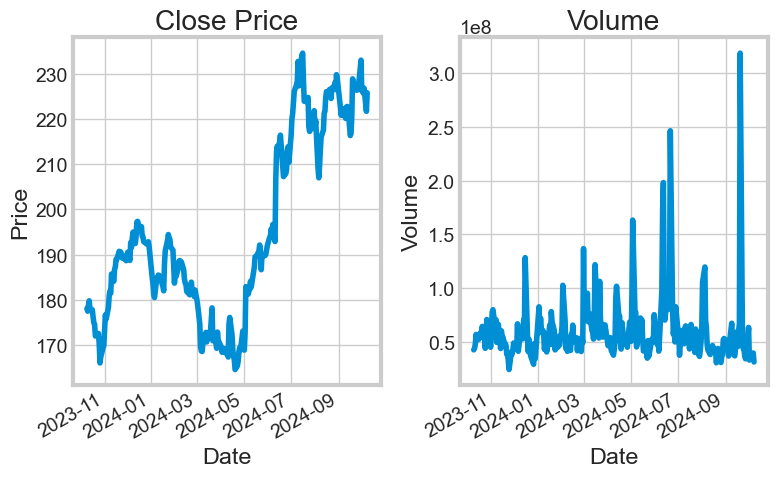

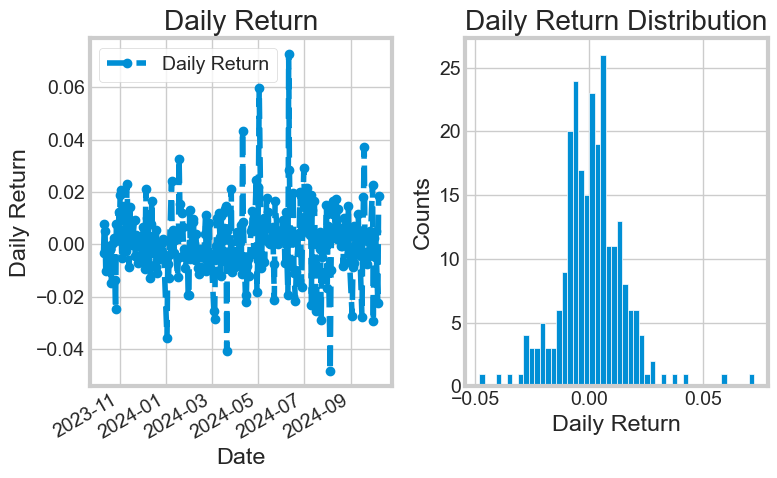

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

df['Close'].plot(ax=ax1)
ax1.set_title('Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

df['Volume'].plot(ax=ax2)
ax2.set_title('Volume')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')

plt.tight_layout()


df['Daily Return'] = df['Close'].pct_change()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Plot Daily Return line plot
df['Daily Return'].plot(ax=ax1, legend=True, linestyle='--', marker='o')
ax1.set_title('Daily Return')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return')

# Plot Daily Return histogram
df['Daily Return'].hist(bins=50, ax=ax2)
ax2.set_title('Daily Return Distribution')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Counts')

# Adjust the layout and display the plot
plt.tight_layout()


## 2. Data pre-processing

As in many other ML areas, we can't shuffle the data due to the sequential characteristics. Thus we'll leave out the most recent price history, to validate on. During training we'll use a sliding window of n days to predict the n+1:th day.

We'll also have to scale the data for our LSTM to train properly. And to reduce data leakage, the scaling should be fit only on the test data

### 2.1 Split into train and validation without data leakage

In [78]:


from typing import List, Tuple
def split(data:List[List], test_size:float, window_size:int) -> Tuple[List, List]:
    # avoid data leakage by non overlapping window
    train_size = int((1-test_size) * len(df))
    
    return dataset[:train_size-window_size, :], dataset[train_size-window_size:,:]
    

data = df.filter(['Close'])
dataset = data.values

TEST_SIZE = 0.1
WINDOW_SIZE = 20

train, test = split(dataset, test_size=TEST_SIZE, window_size=WINDOW_SIZE)



In [79]:
# Plot train and test data

def visualize_data(train, test, window_size):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train)), train, label='Train', color='blue')
    plt.plot(range(len(train), len(train) + len(test)), test, label='Test', color='red')

    window_start = len(train)
    window_end = window_start + window_size
    plt.axvspan(window_start, window_end, color='yellow', alpha=0.3, label='Window')

    plt.title('Train and Test Data')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

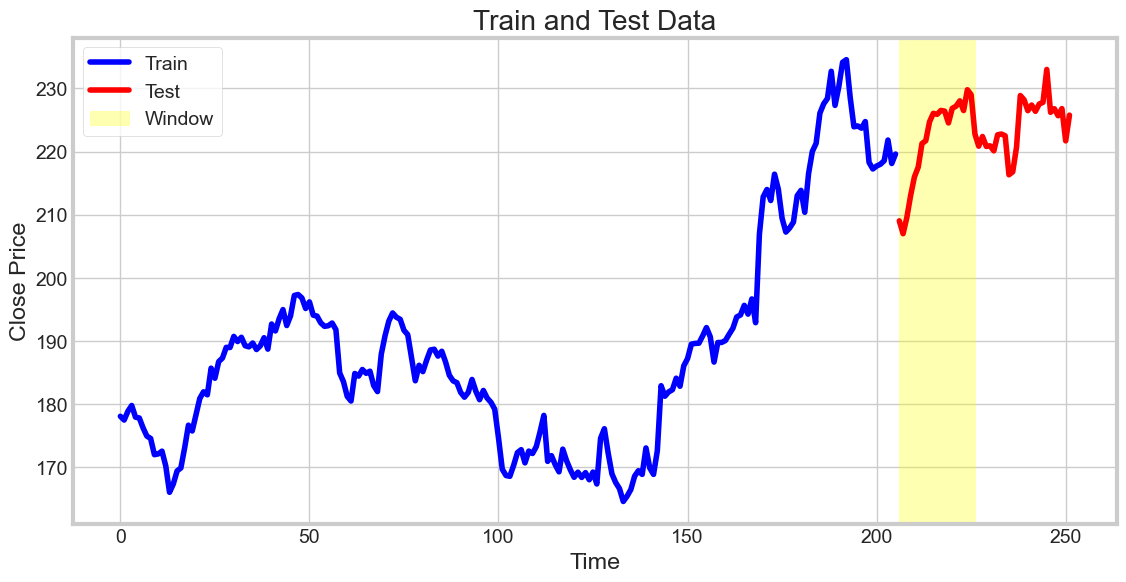

In [80]:
visualize_data(train, test, WINDOW_SIZE)

###  2.2 Scaling the data

In [81]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 0))

# Fit the scaler on the training data
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)



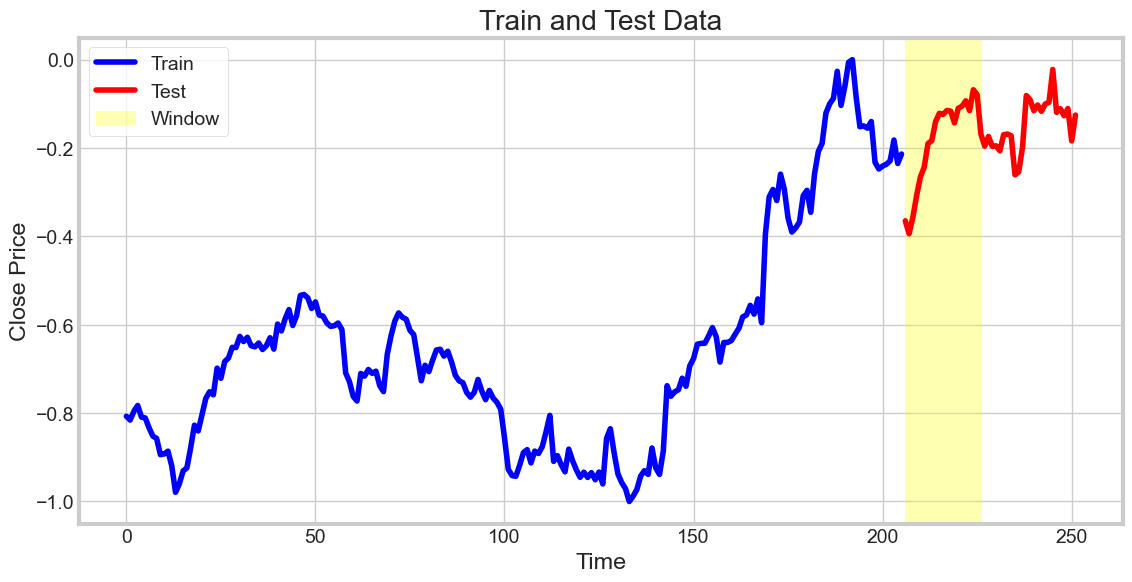

In [82]:
visualize_data(train_scaled, test_scaled, WINDOW_SIZE)

### 2.3 Creating X, y with sliding window

In [83]:
def create_dataset(dataset:List[List], window_size:int):
    # Creating a sliding window
    X = np.array([dataset[i:i+window_size] for i in range(len(dataset) - window_size)])
    Y = dataset[window_size:, 0]
    return X, Y

In [84]:
x_train, y_train = create_dataset(train_scaled, WINDOW_SIZE)
x_test, y_test = create_dataset(test_scaled, WINDOW_SIZE)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(186, 20, 1)
(186,)
(26, 20, 1)
(26,)


## 3. Training LSTM

In [86]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5


/Users/joro/src/ai-projects/stock-market-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0661 - val_loss: 0.0038
Epoch 2/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - val_loss: 0.0037
Epoch 3/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 4/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 5/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0027


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

## 4. Predict Future Stock Prices

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test_inv[0], test_predict[:,0])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [89]:
print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

RMSE: 3.6039653683404373
MAE: 2.7483332707331742


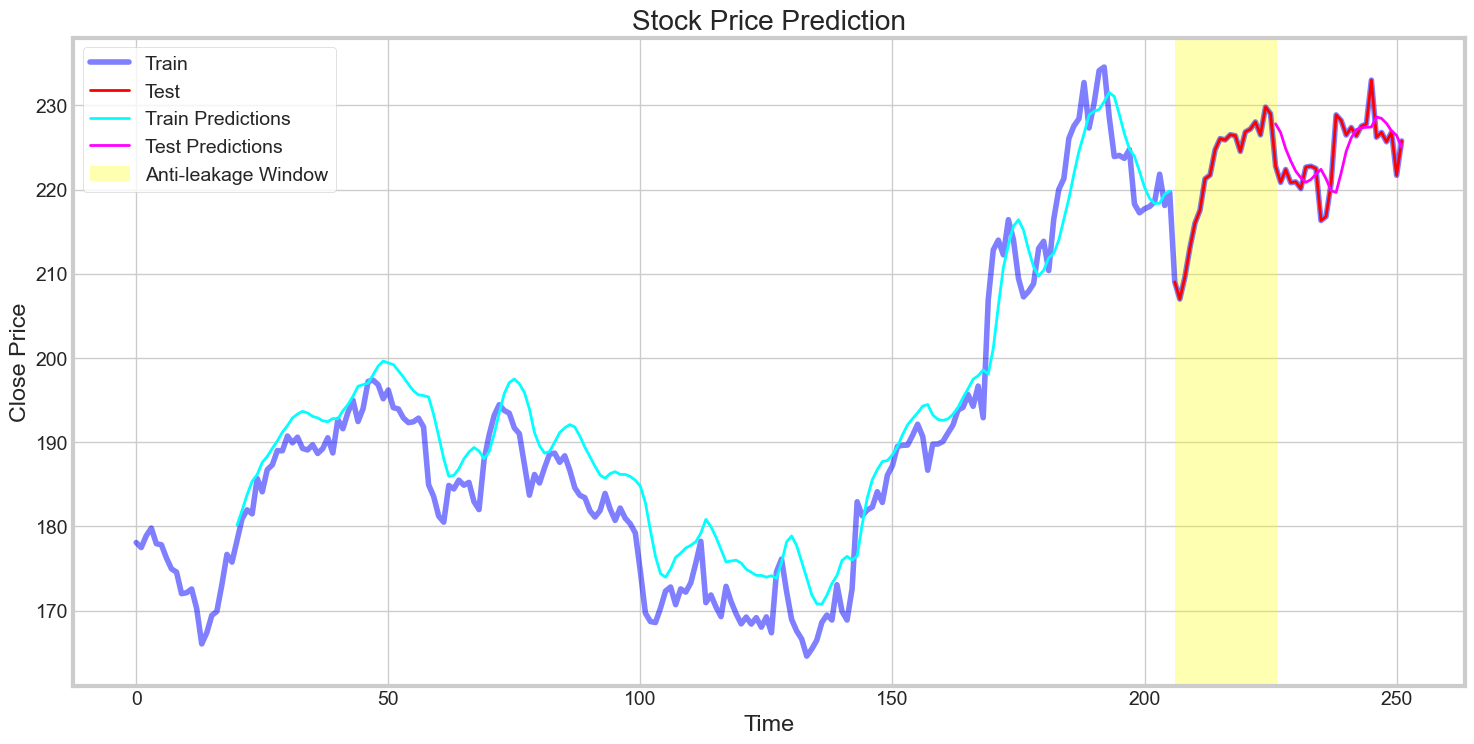

In [88]:
import matplotlib.pyplot as plt

def visualize_data_with_predictions(data, window_size, train_predict, test_predict):
    plt.figure(figsize=(16, 8))
    
    # Calculate the split point between train and test data
    train_size = len(data) - len(test_predict) - window_size
    
    # Plot train and test data
    plt.plot(data, label='Train', color='blue', alpha=0.5)
    plt.plot(range(train_size, len(data)), data[train_size:], label='Test', color='red', linewidth=2)
    
    # Calculate prediction plot indices
    train_predict_start = window_size
    train_predict_end = train_predict_start + len(train_predict)
    test_predict_start = len(data) - len(test_predict)
    test_predict_end = len(data)
    
    # Plot predictions
    plt.plot(range(train_predict_start, train_predict_end), train_predict, label='Train Predictions', color='cyan', linewidth=2)
    plt.plot(range(test_predict_start, test_predict_end), test_predict, label='Test Predictions', color='magenta', linewidth=2)

    # Highlight the window
    plt.axvspan(test_predict_start - window_size, test_predict_start, color='yellow', alpha=0.3, label='Anti-leakage Window')

    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

visualize_data_with_predictions(dataset[:, 0], WINDOW_SIZE, train_predict[:, 0], test_predict[:, 0])